In [1]:
# import required modules
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import pearsonr
from sklearn.gaussian_process import GaussianProcessRegressor as GPR

import seaborn.apionly as sns
sns.set_context("poster")
from IPython.display import display
matplotlib.style.use('ggplot')
%matplotlib inline

In [10]:
# basic EDA of microarray expression data
file_expression = pd.read_csv("../../ADNI_download/ADNI_Gene_Expression_Profile/ADNI_Gene_Expression_Profile.csv",header=None, index_col=0) #, dtype={'INDEX':str})
#print("Overview of the gene expression dataset loaded as pandas table.\n")
#file_expression.describe()

## 1. Data cleaning and merging
The gene expression data provided in ADNI contains information  about gene locus, ~ 49,000 gene expression levels, gene annotation, phase, visit, year of collection etc. This dataset provides rich information but is not well formated. In order to add the gene expression data to the original DREAM challenge data, the gene expression dataframe had to be cleaned and transposed first. After the cleaning of gene expression data, the converted table merged with the Dream challenge table, generated a well formated table for following EDA. 

In [11]:
print("Gene expression dataset loaded before cleaning.\n")
file_expression.head(10)

Overview of the gene expression dataset loaded before cleaning.



,1,2,3,4,5,6,7,8,9,10,...,738,739,740,741,742,743,744,745,746,747
0,,,,,,,,,,,,,,,,,,,,,
Phase,NaN,NaN,ADNIGO,ADNI2,ADNI2,ADNIGO,ADNI2,ADNI2,ADNI2,ADNIGO,...,ADNIGO,ADNI2,ADNIGO,ADNI2,ADNIGO,ADNI2,ADNI2,ADNI2,ADNI2,NaN
Visit,NaN,NaN,m48,v03,v03,m48,v03,v03,v06,bl,...,bl,v03,m60,v03,bl,v03,v03,v03,v06,NaN
SubjectID,NaN,NaN,116_S_1249,037_S_4410,006_S_4153,116_S_1232,099_S_4205,007_S_4467,128_S_0205,003_S_2374,...,022_S_2379,014_S_4668,130_S_0289,141_S_4456,009_S_2381,053_S_4557,073_S_4300,041_S_4014,007_S_0101,NaN
260/280,NaN,NaN,2.05,2.07,2.04,2.03,2.01,2.05,1.95,1.99,...,2.05,2.05,1.98,2.09,1.87,2.03,2.11,1.94,2.06,NaN
260/230,NaN,NaN,0.55,1.54,2.1,1.52,1.6,1.91,1.47,2.07,...,1.9,2.05,1.65,1.56,1.45,1.33,0.27,1.72,1.35,NaN
RIN,NaN,NaN,7.7,7.6,7.2,6.8,7.9,7,7.9,7.2,...,6.7,6.5,6.3,6.4,6.6,6.8,6.2,5.8,6.7,NaN
Affy Plate,NaN,NaN,7,3,6,7,9,4,3,8,...,8,6,9,3,8,5,3,1,4,NaN
YearofCollection,NaN,NaN,2011,2012,2011,2011,2011,2012,2011,2011,...,2011,2012,2011,2012,2011,2012,2011,2011,2012,NaN
ProbeSet,LocusLink,Symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
## Set column names
col_names = file_expression.loc['SubjectID']
col_names[0:2]=['LocusLink','Symbol']
#col_names
file_expression.columns = list(col_names)
#file_expression.head()

In [13]:
# Reformat the table for easy processing
transformed_table = file_expression
transformed_table = transformed_table.drop(['LocusLink','Symbol'],axis=1)
transformed_table = transformed_table.drop(transformed_table.columns[-1:],axis=1)
#transformed_table = transformed_table.drop(['SubjectID'])
transformed_table = transformed_table.T
transformed_table = transformed_table.rename(columns = {'SubjectID':'PTID'})
print("Gene expression dataset glance after cleaning.\n")
transformed_table.head()

Gene expression dataset glance after cleaning.



,Phase,Visit,PTID,260/280,260/230,RIN,Affy Plate,YearofCollection,ProbeSet,11715100_at,...,AFFX-r2-TagH_at,AFFX-r2-TagIN-3_at,AFFX-r2-TagIN-5_at,AFFX-r2-TagIN-M_at,AFFX-r2-TagJ-3_at,AFFX-r2-TagJ-5_at,AFFX-r2-TagO-3_at,AFFX-r2-TagO-5_at,AFFX-r2-TagQ-3_at,AFFX-r2-TagQ-5_at
116_S_1249,ADNIGO,m48,116_S_1249,2.05,0.55,7.7,7,2011,NaN,2.237,...,2.355,2.624,2.01,2.906,2.463,2.05,2.06,1.858,2.028,2.162
037_S_4410,ADNI2,v03,037_S_4410,2.07,1.54,7.6,3,2012,NaN,2.294,...,2.1,2.82,1.726,2.465,2.26,1.933,1.717,2.208,2.058,1.882
006_S_4153,ADNI2,v03,006_S_4153,2.04,2.1,7.2,6,2011,NaN,2.14,...,2.165,2.455,1.84,2.681,2.251,1.985,1.77,2.184,2.007,2.134
116_S_1232,ADNIGO,m48,116_S_1232,2.03,1.52,6.8,7,2011,NaN,2.062,...,2.094,2.599,1.837,2.713,2.158,1.916,1.878,2.163,2.185,2.099
099_S_4205,ADNI2,v03,099_S_4205,2.01,1.6,7.9,9,2011,NaN,2.04,...,1.973,2.544,1.909,2.548,2.266,2.077,1.838,2.085,1.941,1.883


In [14]:
print("Gene expression dataset summary after cleaning.\n")
transformed_table.describe()

Gene expression dataset summary after cleaning.



,Phase,Visit,PTID,260/280,260/230,RIN,Affy Plate,YearofCollection,ProbeSet,11715100_at,...,AFFX-r2-TagH_at,AFFX-r2-TagIN-3_at,AFFX-r2-TagIN-5_at,AFFX-r2-TagIN-M_at,AFFX-r2-TagJ-3_at,AFFX-r2-TagJ-5_at,AFFX-r2-TagO-3_at,AFFX-r2-TagO-5_at,AFFX-r2-TagQ-3_at,AFFX-r2-TagQ-5_at
count,744,744,744,744,744,744,744,744,0.0,744,...,744.000,744.00,744.000,744.000,744.000,744.000,744.000,744.000,744.000,744.000
unique,2,12,744,40,173,38,9,4,0.0,450,...,389.000,440.00,374.000,434.000,395.000,360.000,352.000,431.000,382.000,399.000
top,ADNI2,v03,116_S_4209,2.03,1.65,7.1,3,2011,NaN,2.428,...,2.181,2.71,1.828,2.613,2.337,1.983,1.849,2.262,1.925,2.125
freq,449,357,1,73,13,61,88,383,NaN,5,...,7.000,7.00,7.000,6.000,12.000,9.000,9.000,6.000,7.000,7.000


In [16]:
## Combine gene expression data with dream data
dream_data = pd.read_csv('../../ADNI_download/AD_Challenge_Training_Data_Clinical_Updated_7.22.2014/ADNI_Training_Q2_APOE_July22.2014.csv')
print("Dream data 2nd question training set glance.\n")
dream_data.head()

Dream data 2nd question training set glance.



,RID,PTID,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,ABETA,SAGE.Q2,APOE Genotype
0,5,011_S_0005,73.7,Male,16,0,29,115.0,1,"3,3"
1,19,067_S_0019,73.1,Female,18,0,29,260.0,0,"2,3"
2,31,023_S_0031,77.7,Female,18,0,30,240.0,0,"3,3"
3,43,018_S_0043,76.2,Male,16,0,29,175.0,1,"2,3"
4,47,100_S_0047,84.7,Male,20,0,30,252.0,0,"2,3"


In [17]:
print("Dream data 2nd question training set summary.\n")
dream_data.describe()

Dream data 2nd question training set summary.



,RID,AGE,PTEDUCAT,APOE4,MMSE,ABETA,SAGE.Q2
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,2543.375000,75.309091,16.255682,0.272727,29.028409,195.500000,0.460227
std,1874.399901,5.364692,2.600543,0.517737,1.239488,53.370559,0.499838
min,5.000000,62.000000,8.000000,0.000000,24.000000,75.000000,0.000000
25%,558.000000,71.775000,14.000000,0.000000,29.000000,149.950000,0.000000
50%,4032.500000,74.900000,16.000000,0.000000,29.000000,202.000000,0.000000
75%,4281.250000,78.400000,18.000000,0.000000,30.000000,240.000000,1.000000
max,4516.000000,89.600000,20.000000,2.000000,30.000000,302.800000,1.000000


In [19]:
data_common = pd.merge(left=dream_data, right=transformed_table, how='inner')
data_common = data_common.sort_values(by='ABETA')
print("Combine the gene expression data with Dream data by overlapping patient id.\n")
data_common.head()

,RID,PTID,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,ABETA,SAGE.Q2,APOE Genotype,...,AFFX-r2-TagH_at,AFFX-r2-TagIN-3_at,AFFX-r2-TagIN-5_at,AFFX-r2-TagIN-M_at,AFFX-r2-TagJ-3_at,AFFX-r2-TagJ-5_at,AFFX-r2-TagO-3_at,AFFX-r2-TagO-5_at,AFFX-r2-TagQ-3_at,AFFX-r2-TagQ-5_at
40,984,021_S_0984,76.6,Male,14,1,30,75.0,1,"3,4",...,2.258,3.229,1.817,2.565,2.13,1.829,1.596,2.394,1.887,2.09
77,4179,033_S_4179,83.0,Male,20,2,30,82.7,1,"4,4",...,2.196,2.655,1.883,2.46,2.24,2.002,2.052,2.262,1.982,2.024
95,4339,082_S_4339,84.3,Male,17,2,29,90.7,1,"4,4",...,2.274,2.747,1.918,2.67,2.402,1.792,1.808,2.588,2.013,2.304
124,4474,031_S_4474,85.6,Male,18,0,28,92.5,1,"3,3",...,2.178,2.941,1.878,3.114,2.421,2.028,1.76,2.253,1.94,2.089
94,4335,021_S_4335,71.7,Female,15,0,30,95.4,1,"3,3",...,2.342,2.579,1.905,2.725,2.472,1.804,2.122,2.035,1.932,1.942


In [20]:
print("The dimension for the new merged table is:\n")
data_common.shape
#data_common.columns[0:30]

The dimension for the new merged table is:



(130, 49404)

## 2. EDA

## 1) After data cleaning and merging, the first question we ask is: is amyloid beta level distribution bimodal in the data we work with? In addition, are the two classes that we are going to classify balanced? 

Fig1 addresses this question, showing bimodal distribution in both the original dream data and the merged table and well-balanced data .

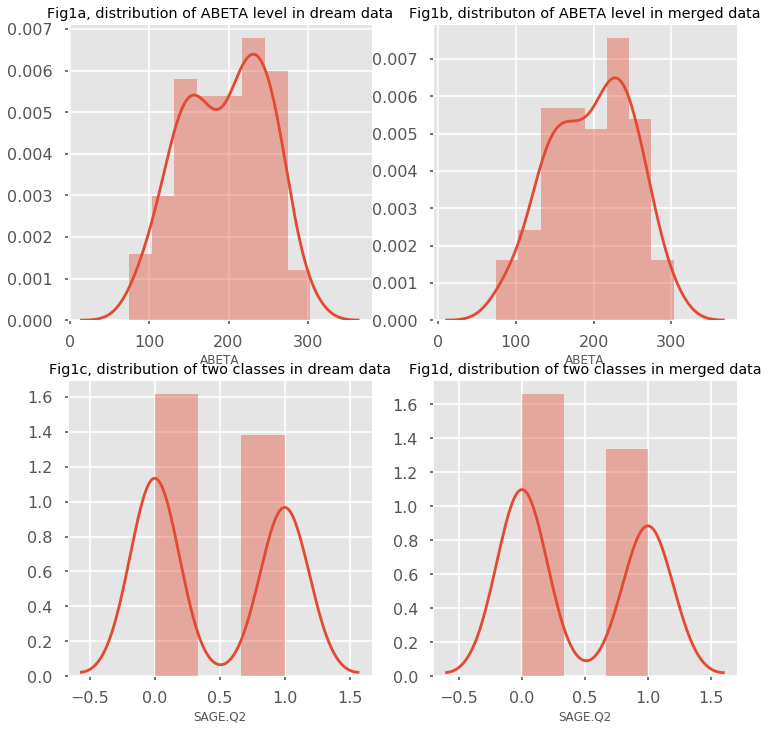

In [23]:
# Check distribution of amyloid-beta 42 level (ABETA) and class (SAGE.Q2)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
sns.distplot(dream_data['ABETA'], ax=axes[0,0])
axes[0,0].set_title("Fig1a, distribution of ABETA level in dream data")
sns.distplot(data_common['ABETA'], ax=axes[0,1])
axes[0,1].set_title("Fig1b, distributon of ABETA level in merged data")
sns.distplot(dream_data['SAGE.Q2'], ax=axes[1,0])
axes[1,0].set_title("Fig1c, distribution of two classes in dream data")
sns.distplot(data_common['SAGE.Q2'], ax=axes[1,1])
axes[1,1].set_title("Fig1d, distribution of two classes in merged data");

## 2) Is there any correlation/difference in the two classes with regard to age, apo4 level, MMSE score, and year of collection? 

Fig2 addresses these questions. The Age of patients in class 0 are more concentrated around 75 compared to class 1 (Fig2a). The year of collection of patient samples in class 0 are more spread out than in class 1 (Fig2d). The Apoe4 level in class 0 is much more concentrated near 0, whereas class 1 shows more variation in both directions (Fig2b). When comparing Apoe4 level with ABETA level, there is a clear negative correlation between the two (Fig2f). The MMSE score distribution in class 0 is lower than in class 1 (Fig2c). The scatterplot comparing ABETA level vs MMSE score (Fig2e) showed similar trend, implying high levels of beta-amyloid might correlate with lower cognition. 


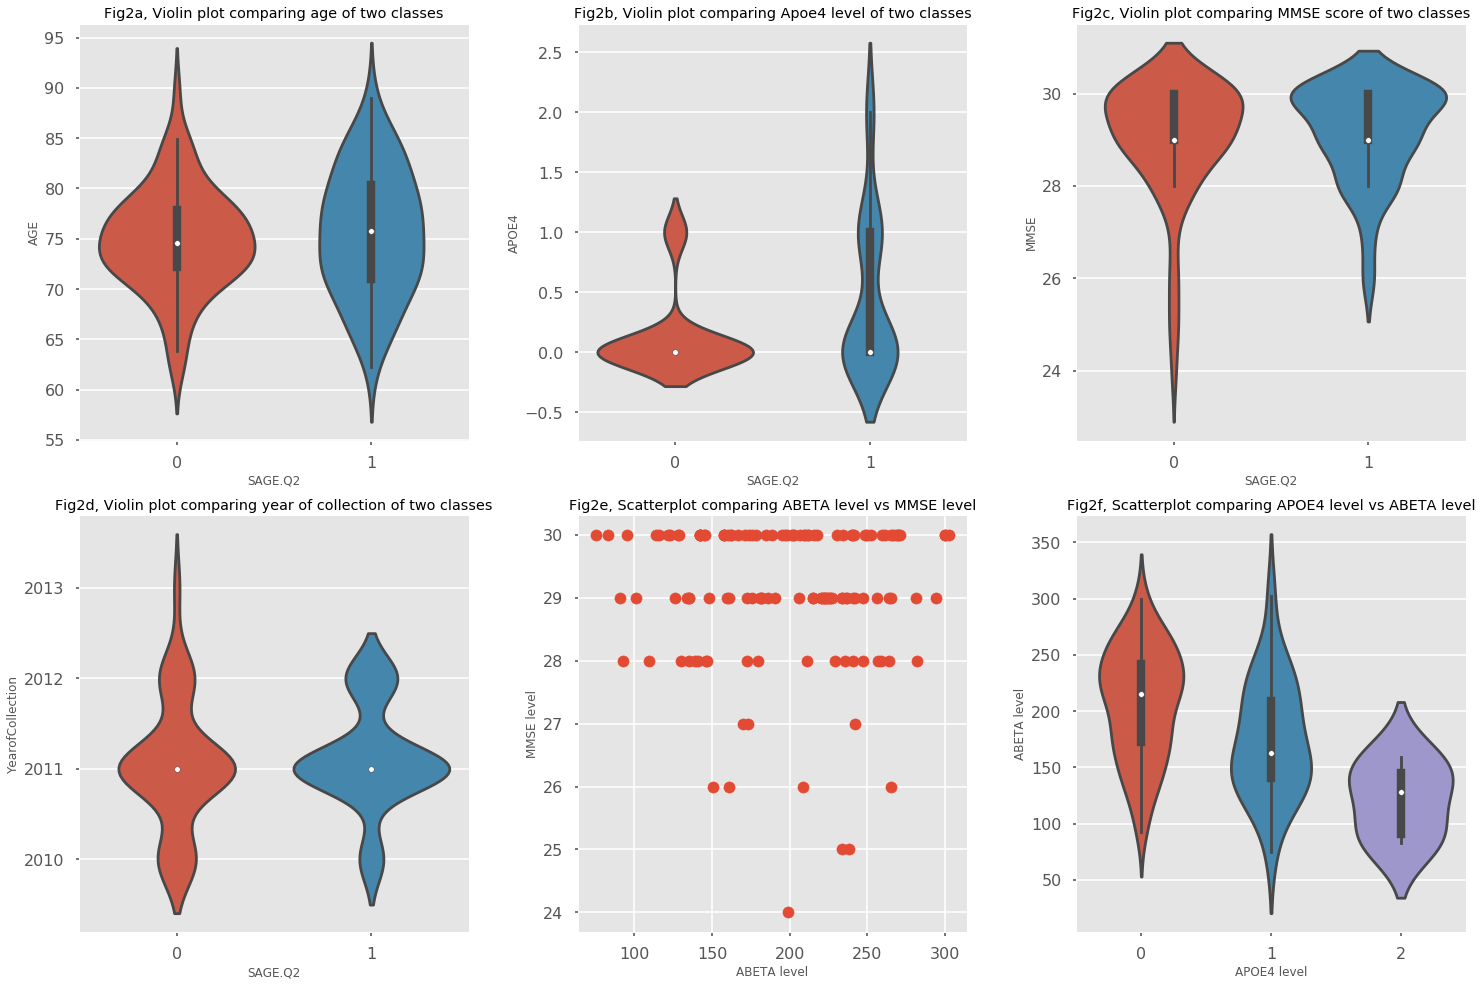

In [24]:
# Check distribution of amyloid-beta 42 level (ABETA) and class (SAGE.Q2)
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(21,15))
sns.violinplot(data_common['SAGE.Q2'], data_common['AGE'], ax=axes[0,0])
axes[0,0].set_title("Fig2a, Violin plot comparing age of two classes")

sns.violinplot(data_common['SAGE.Q2'], data_common['APOE4'], ax=axes[0,1])
axes[0,1].set_title("Fig2b, Violin plot comparing Apoe4 level of two classes")

sns.violinplot(data_common['SAGE.Q2'], data_common['MMSE'], ax=axes[0,2])
axes[0,2].set_title("Fig2c, Violin plot comparing MMSE score of two classes")

sns.violinplot(data_common['SAGE.Q2'], data_common.YearofCollection.convert_objects(convert_numeric=True), ax=axes[1,0])
axes[1,0].set_title("Fig2d, Violin plot comparing year of collection of two classes")

axes[1,1].scatter(data_common['ABETA'],data_common['MMSE'])
axes[1,1].set_xlabel('ABETA level')
axes[1,1].set_ylabel('MMSE level')
axes[1,1].set_title("Fig2e, Scatterplot comparing ABETA level vs MMSE level")

sns.violinplot(data_common['APOE4'], data_common['ABETA'], ax=axes[1,2])
axes[1,2].set_ylabel('ABETA level')
axes[1,2].set_xlabel('APOE4 level')
axes[1,2].set_title("Fig2f, Scatterplot comparing APOE4 level vs ABETA level")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## 3) How does high level look of gene expression profile differ between the two classes? 

To address this question, we made a heatmap plot with each row correspond to a patient sample with class label on the side, each column correspond to a gene (We included 100 random genes in the plot for illustration purposes). If the gene expression profile of the two classes are distinctly different, we would expect the heatmap clustering on the y-axis (class bar on the left side of the heatmap) be very well separated between the two classes (red vs blue). The heatmap suggests the gene expression profiles between the two classes are not distinctly different based on this limited subset of genes. However, some of the samples do cluster close, showing thick red/blue class bars on the left, suggesting there might be potential that gene expression profile can help separate the two classes.

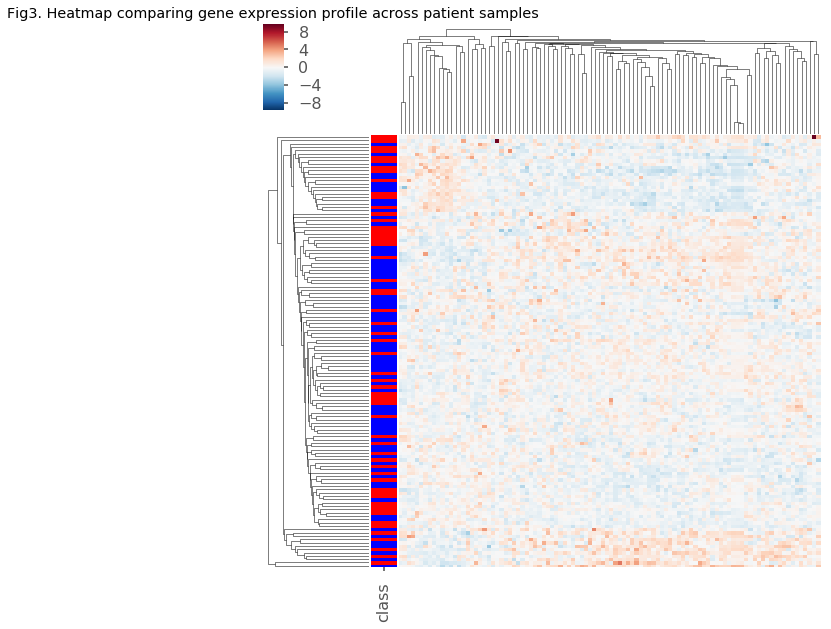

In [49]:
## Check gene expression profile difference by heatmap visualization
select_data = data_common[data_common.columns[119:219]]
select_data = select_data.convert_objects(convert_numeric=True)
select_data['class'] = data_common['SAGE.Q2']
exp_table = select_data.pop('class')
exp = dict(zip(exp_table.unique(), 'rbg'))
row_colors = exp_table.map(exp);
sns.clustermap(select_data, row_colors=row_colors, z_score=1, cmap="RdBu_r", mask=select_data.isnull(),yticklabels=False,xticklabels=False)
#plt.setp(sns.clustermap(select_data, row_colors=row_colors, z_score=1, cmap="RdBu_r", mask=select_data.isnull()).ax_heatmap.set_xlabel('genes'))
#plt.setp(sns.clustermap(select_data, row_colors=row_colors, z_score=1, cmap="RdBu_r", mask=select_data.isnull()).ax_heatmap.set_ylabel('patients'));
plt.title("Fig3. Heatmap comparing gene expression profile across patient samples");


# Summary

